In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import joblib
import warnings
import shap

In [2]:
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Set display options to show all columns if requested
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [4]:
# Load the dataset
df = pd.read_csv('prepared_dataset_unfinished_game.csv')

# View the first 20 rows of the dataset
print(df.head(20))

    veteran  hotStreak  win.x   item0  firstBloodKill  firstTowerKill  firstTowerAssist  creepsPerMinDeltas_010  xpPerMinDeltas_010  goldPerMinDeltas_010  csDiffPerMinDeltas_010  damageTakenPerMinDeltas_010  damageTakenDiffPerMinDeltas_010  creepsPerMinDeltas_1020  xpPerMinDeltas_1020  goldPerMinDeltas_1020  csDiffPerMinDeltas_1020  damageTakenPerMinDeltas_1020  damageTakenDiffPerMinDeltas_1020  firstBlood  firstTower  firstDragon  firstRiftHerald  spell1Id  spell2Id  tier_CHALLENGER  tier_DIAMOND  tier_GOLD  tier_GRANDMASTER  tier_IRON  tier_MASTER  tier_PLATINUM  tier_SILVER  role_DUO_CARRY  role_DUO_SUPPORT  role_NONE  role_SOLO  lane_JUNGLE  lane_MIDDLE  lane_TOP
0       0.0        0.0    0.0  3157.0             0.0             0.0               0.0                     0.8               269.4                 227.6                  -0.065                        464.0                             8.15                      2.0                333.1                  283.4                

## Prepare data before evaluating models

In [5]:
# Normalize the data to later use it in the models
# Not all of the columns need to be normalized, so it will be selected the ones that need it
cols_to_normalize = [
    'item0', 'creepsPerMinDeltas_010', 'xpPerMinDeltas_010', 'goldPerMinDeltas_010', 'csDiffPerMinDeltas_010', 'damageTakenPerMinDeltas_010', 'damageTakenDiffPerMinDeltas_010',
    'creepsPerMinDeltas_1020', 'xpPerMinDeltas_1020', 'goldPerMinDeltas_1020', 'csDiffPerMinDeltas_1020', 'damageTakenPerMinDeltas_1020', 'damageTakenDiffPerMinDeltas_1020',
    'spell1Id', 'spell2Id', 
]

# Normalize the selected columns using RobustScaler in order to reduce the influence of outliers
scaler = RobustScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# View the first 20 rows of the dataset after normalization
print(df.head(20))

    veteran  hotStreak  win.x     item0  firstBloodKill  firstTowerKill  firstTowerAssist  creepsPerMinDeltas_010  xpPerMinDeltas_010  goldPerMinDeltas_010  csDiffPerMinDeltas_010  damageTakenPerMinDeltas_010  damageTakenDiffPerMinDeltas_010  creepsPerMinDeltas_1020  xpPerMinDeltas_1020  goldPerMinDeltas_1020  csDiffPerMinDeltas_1020  damageTakenPerMinDeltas_1020  damageTakenDiffPerMinDeltas_1020  firstBlood  firstTower  firstDragon  firstRiftHerald  spell1Id  spell2Id  tier_CHALLENGER  tier_DIAMOND  tier_GOLD  tier_GRANDMASTER  tier_IRON  tier_MASTER  tier_PLATINUM  tier_SILVER  role_DUO_CARRY  role_DUO_SUPPORT  role_NONE  role_SOLO  lane_JUNGLE  lane_MIDDLE  lane_TOP
0       0.0        0.0    0.0  0.049397             0.0             0.0               0.0               -0.737705           -0.495935             -0.504172               -0.056522                     0.292319                         0.062289                -0.545455            -0.812842              -0.692815            

In [6]:
# Split the dataset into training and testing sets using cross-validation
# The target variable is the win.x column, which indicates whether the player won or lost the game
# The features are all the other columns in the dataset
target = 'win.x'
X = df.drop(columns=[target])
y = df[target]

# 80% of the data will be used for training and 20% for testing
# The X_train and X_test variables will contain the features for the training and testing sets, respectively
# The y_train and y_test variables will contain the target variable for the training and testing sets, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the X training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (194699, 39)
X_test shape: (48675, 39)


## Important functions defined

In [7]:
# Initialize a DataFrame to store the results from the models
models_results = pd.DataFrame(columns=[
    'Modelo', 'Configuración', 'Exactitud', 'Precisión', 'Sensibilidad', 'F1-Score', 'AUC'
])

# Function to evaluate the model and storing the results
def evaluate_model(model_name, config, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (win)

    # Calculate the metrics
    results = pd.DataFrame([{
        'Modelo': model_name,
        'Configuración': config,
        'Exactitud': accuracy_score(y_test, y_pred),
        'Precisión': precision_score(y_test, y_pred),
        'Sensibilidad': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_prob)
    }])

    # return the results and the predictions
    return results, y_pred, y_pred_prob

# Function to plot the ROC curve
def plot_roc_curve(y_test, y_pred_prob, model_name, config):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    if y_pred_prob is not None:
        plt.plot(fpr, tpr, label=f'{model_name} ({config})')
        plt.title('Curva ROC')
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
    else:
        return
    
# Function to plot the confusion matrix from a given model predictions
def plot_confusion_matrix(y_test, y_pred, model_name, config):
    cm = confusion_matrix(y_test, y_pred)
    matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
    matrix.plot(cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name} ({config})')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

# Function to plot the multilayer perceptron loss curve during training along with the accuracy during validation
def plot_mlp_loss_curve(mlp_model, model_name='MLPClassifier'):
    plt.figure(figsize=(8, 6))
    plt.plot(mlp_model.loss_curve_, label='Pérdida de entrenamiento')
    if hasattr(mlp_model, 'validation_scores_'):
        plt.plot(mlp_model.validation_scores_, label='Precisión en validación', linestyle='--')

    plt.title(f'Curva de pérdida y precisión - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida / Precisión')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Evaluation of the base models

In [8]:
# Load the base models
# These models are already trained and saved in the './models/base/' folder
logistic_regression = joblib.load('./models/base/logistic_regression_base_model.pkl')
random_forest = joblib.load('./models/base/random_forest_base_model.pkl')
lgb_model = joblib.load('./models/base/lgbm_base_model.pkl')
mlpc = joblib.load('./models/base/mlp_base_model.pkl')

In [9]:
# Evaluate the base models
res_lr_base, y_pred_lr, y_prob_lr = evaluate_model('Logistic Regression', 'Base', logistic_regression, X_test, y_test)
res_rf_base, y_pred_rf, y_prob_rf = evaluate_model('Random Forest', 'Base', random_forest, X_test, y_test)
res_lgb_base, y_pred_lgb, y_prob_lgb = evaluate_model('LGBMClassifier', 'Base', lgb_model, X_test, y_test)
res_mlp_base, y_pred_mlp, y_prob_mlp = evaluate_model('MLPClassifier', 'Base', mlpc, X_test, y_test)

# Add their results to the DataFrame
models_results = pd.concat([models_results, res_lr_base], ignore_index=True)
models_results = pd.concat([models_results, res_rf_base], ignore_index=True)
models_results = pd.concat([models_results, res_lgb_base], ignore_index=True)
models_results = pd.concat([models_results, res_mlp_base], ignore_index=True)

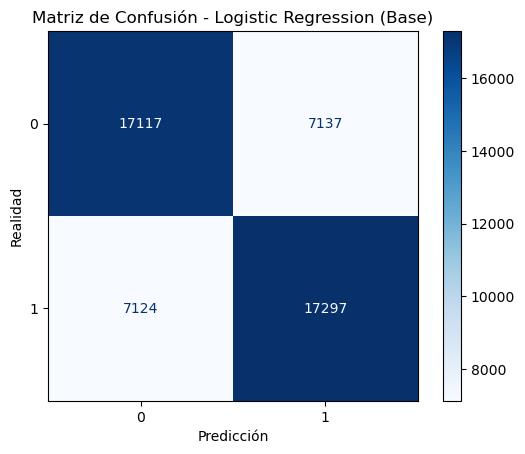

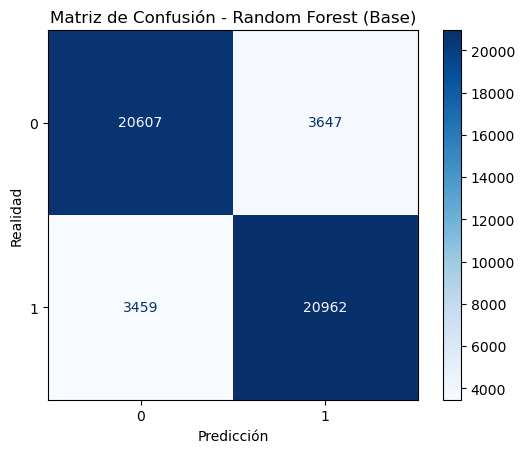

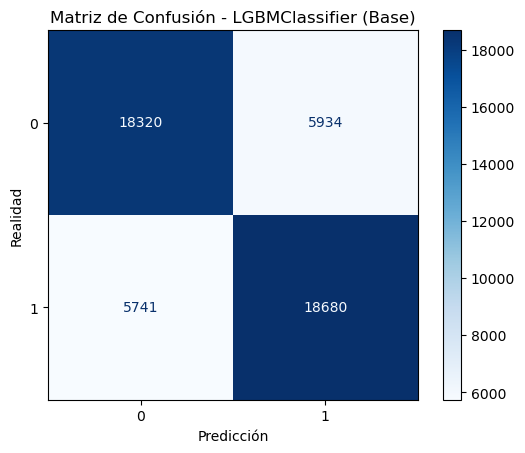

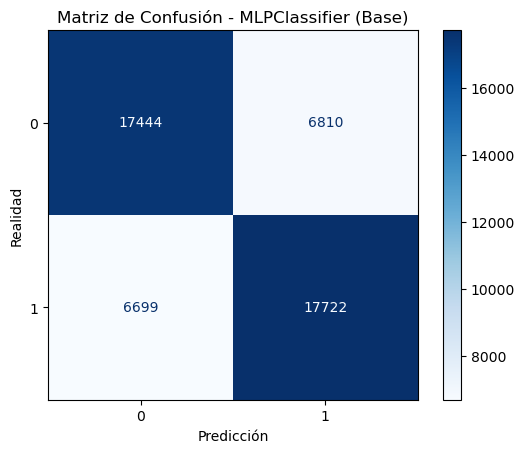

In [10]:
# Show confusion matrices for the base models
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression', 'Base')
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest', 'Base')
plot_confusion_matrix(y_test, y_pred_lgb, 'LGBMClassifier', 'Base')
plot_confusion_matrix(y_test, y_pred_mlp, 'MLPClassifier', 'Base')

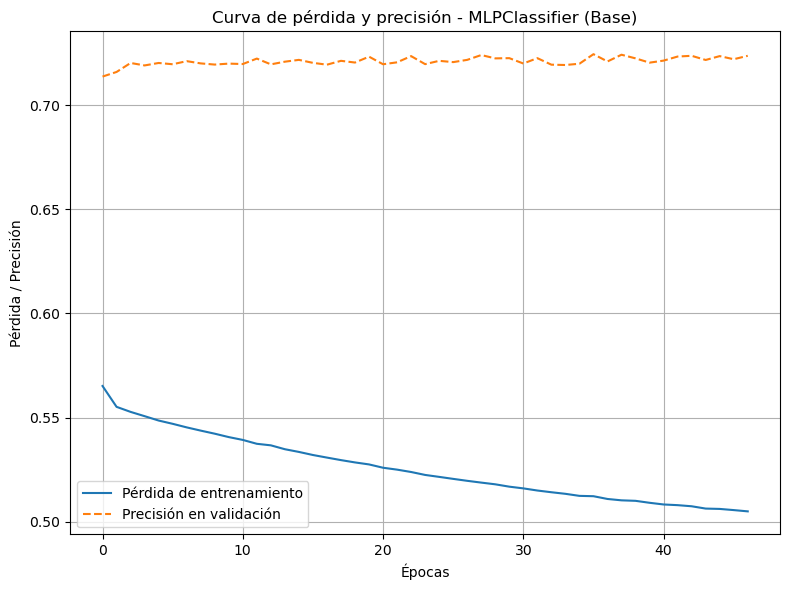

In [11]:
# Show the loss curve for the MLP Classifier during training, along with the accuracy during validation
plot_mlp_loss_curve(mlpc, 'MLPClassifier (Base)')

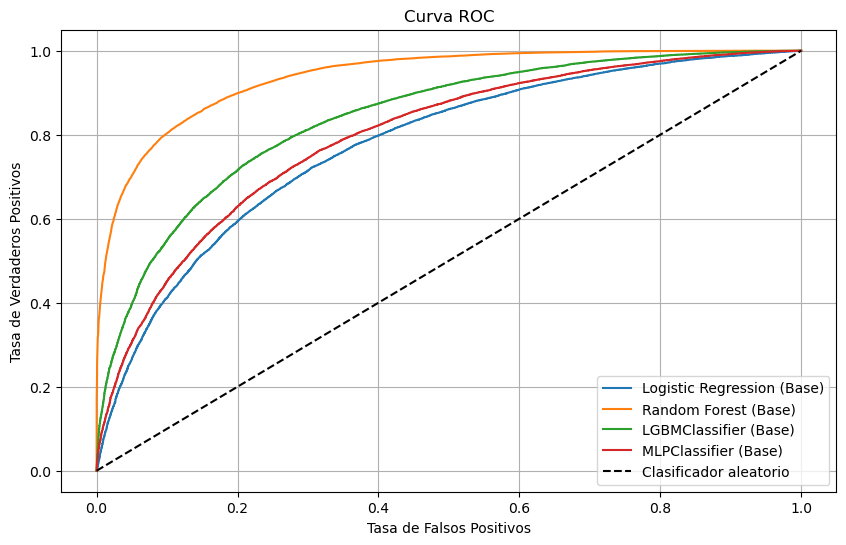

<Figure size 640x480 with 0 Axes>

In [12]:
# Initialize the figure for the ROC curve
plt.figure(figsize=(10, 6))

# Base models list with their names and probabilities
base_models = [
    ('Logistic Regression', y_prob_lr),
    ('Random Forest', y_prob_rf),
    ('LGBMClassifier', y_prob_lgb),
    ('MLPClassifier', y_prob_mlp)
]

# Plot the ROC curves for the base models
for model_name, y_prob in base_models:
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (Base)')

# Display a diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
# Set the rest of the plot properties
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()
plt.tight_layout()
plt.show()

                Modelo Configuración  Exactitud  Precisión  Sensibilidad  F1-Score       AUC
1        Random Forest          Base   0.854011   0.851802      0.858360  0.855068  0.938023
2       LGBMClassifier          Base   0.760144   0.758918      0.764915  0.761905  0.839454
3        MLPClassifier          Base   0.722465   0.722403      0.725687  0.724041  0.795102
0  Logistic Regression          Base   0.707016   0.707907      0.708284  0.708095  0.774657 



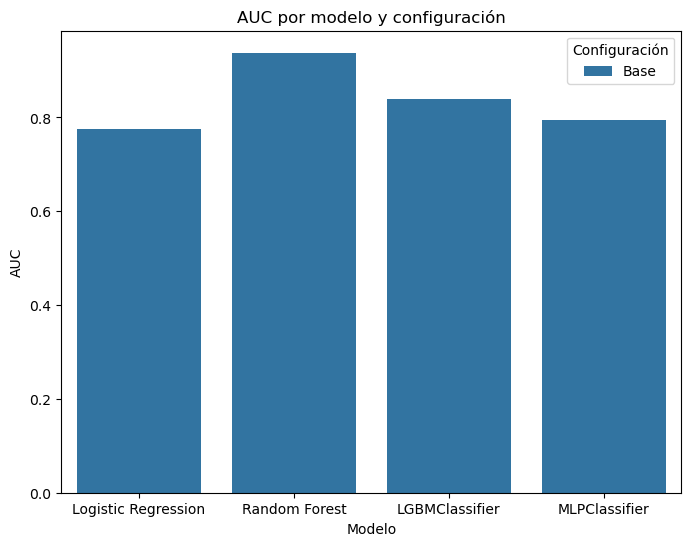

In [13]:
# Show the results of the base models
print(models_results.sort_values(by='AUC', ascending=False), '\n')

# Plot the AUC for the base models with their configurations
plt.figure(figsize=(8, 6))
sns.barplot(data=models_results, x='Modelo', y='AUC', hue='Configuración')
plt.title('AUC por modelo y configuración')
plt.xlabel('Modelo')
plt.ylabel('AUC')
plt.show()

## Evaluation of the Randomized Search models

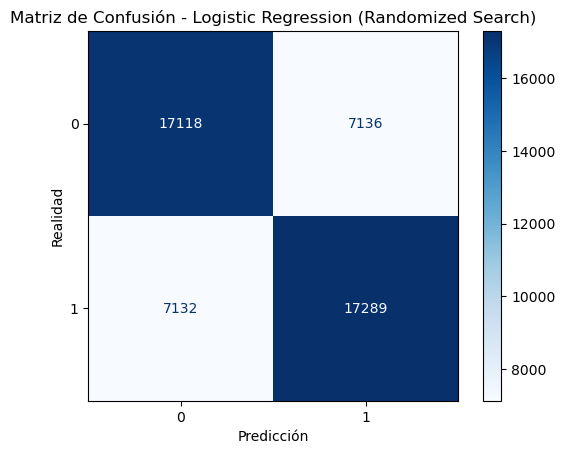

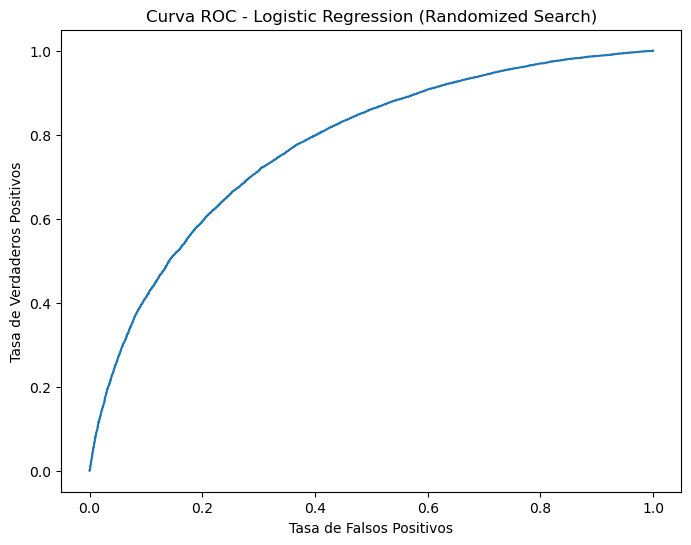

In [14]:
# Load the best Logistic Regression model from RandomizedSearchCV
# This model is already trained and saved in the './models/randomized/' folder
best_lr_model_randomized = joblib.load('./models/randomized/best_lr_model_randomized.pkl')

# Evaluate the best Logistic Regression model
res_lr_randomized, y_pred_lr_randomized, y_prob_lr_randomized = evaluate_model('Logistic Regression', 'Randomized Search', best_lr_model_randomized, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_lr_randomized, 'Logistic Regression', 'Randomized Search')

# Store the results of the best Logistic Regression model
models_results = pd.concat([models_results, res_lr_randomized], ignore_index=True)

# Plot ROC curve for Logistic Regression with Randomized Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_lr_randomized, 'Logistic Regression', 'Randomized Search')
plt.title('Curva ROC - Logistic Regression (Randomized Search)')
plt.show()

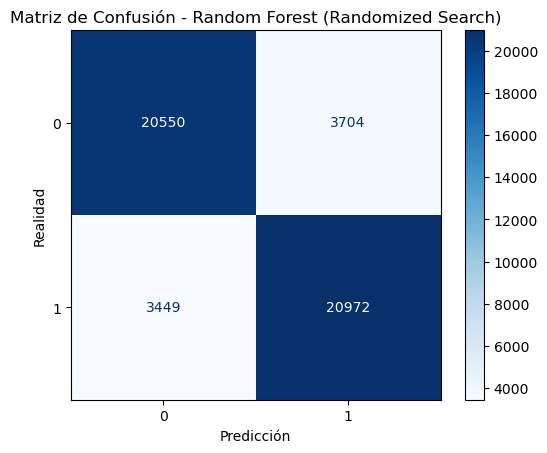

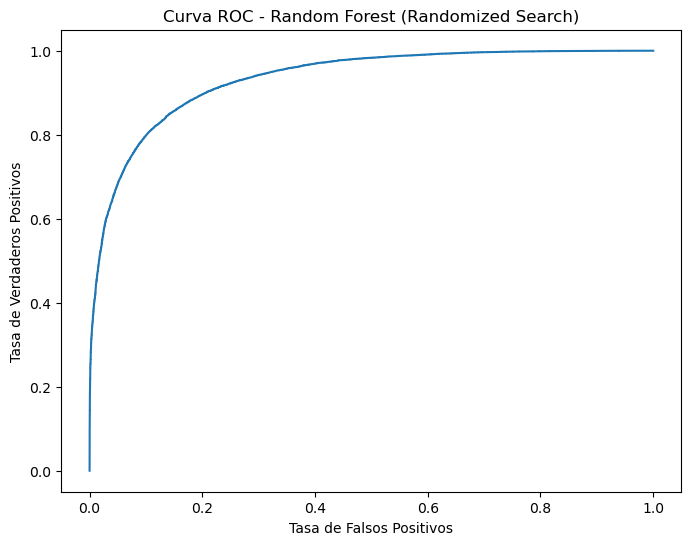

In [15]:
# Load the best Random Forest model from RandomizedSearchCV
# This model is already trained and saved in the './models/randomized/' folder
best_rf_model_randomized = joblib.load('./models/randomized/best_rf_model_randomized.pkl')

# Evaluate the best Random Forest model
res_rf_randomized, y_pred_rf_randomized, y_prob_rf_randomized = evaluate_model('Random Forest', 'Randomized Search', best_rf_model_randomized, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_rf_randomized, 'Random Forest', 'Randomized Search')

# Store the results of the best Random Forest model
models_results = pd.concat([models_results, res_rf_randomized], ignore_index=True)

# Plot ROC curve for Random Forest with Randomized Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_rf_randomized, 'Random Forest', 'Randomized Search')
plt.title('Curva ROC - Random Forest (Randomized Search)')
plt.show()

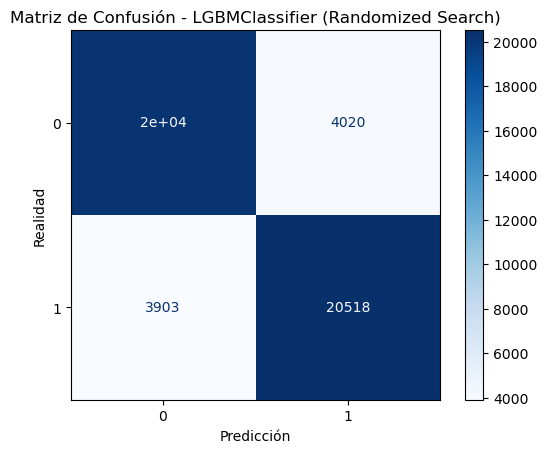

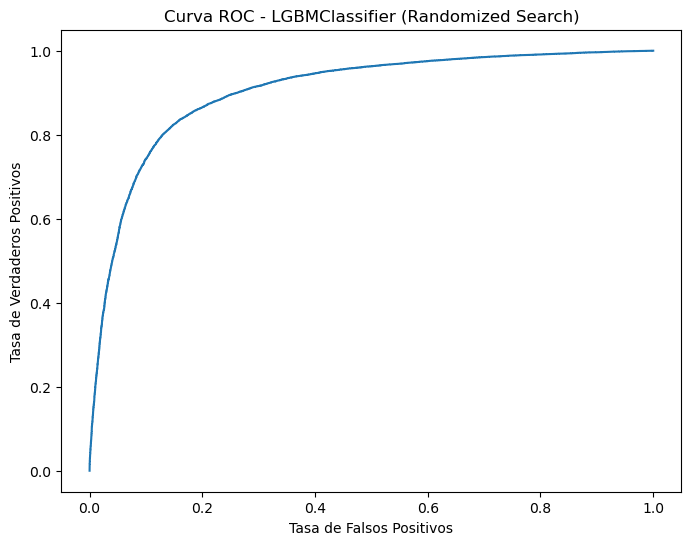

In [16]:
# Load the best LightGBM model from RandomizedSearchCV
# This model is already trained and saved in the './models/randomized/' folder
best_lgb_model_randomized = joblib.load('./models/randomized/best_lgb_model_randomized.pkl')

# Evaluate the best LightGBM model
res_lgb_randomized, y_pred_lgb_randomized, y_prob_lgb_randomized = evaluate_model('LGBMClassifier', 'Randomized Search', best_lgb_model_randomized, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_lgb_randomized, 'LGBMClassifier', 'Randomized Search')

# Store the results of the best LightGBM model
models_results = pd.concat([models_results, res_lgb_randomized], ignore_index=True)

# Plot ROC curve for LGBM Classifier with Randomized Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_lgb_randomized, 'LGBMClassifier', 'Randomized Search')
plt.title('Curva ROC - LGBMClassifier (Randomized Search)')
plt.show()

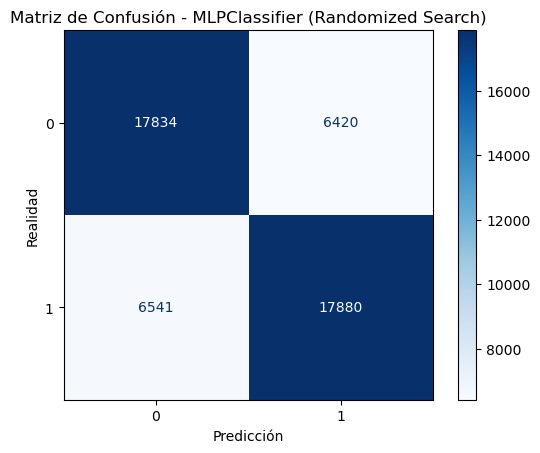

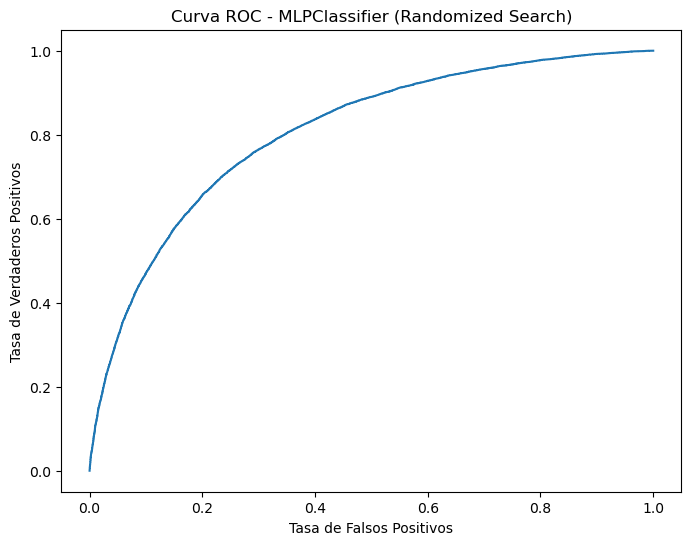

In [17]:
# Load the best MLP Classifier model from RandomizedSearchCV
# This model is already trained and saved in the './models/randomized/' folder
best_mlp_model_randomized = joblib.load('./models/randomized/best_mlp_model_randomized.pkl')

# Evaluate the best MLP Classifier model
res_mlp_randomized, y_pred_mlp_randomized, y_prob_mlp_randomized = evaluate_model('MLPClassifier', 'Randomized Search', best_mlp_model_randomized, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_mlp_randomized, 'MLPClassifier', 'Randomized Search')

# Store the results of the best MLP Classifier model
models_results = pd.concat([models_results, res_mlp_randomized], ignore_index=True)

# Plot ROC curve for MLP Classifier with Randomized Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_mlp_randomized, 'MLPClassifier', 'Randomized Search')
plt.title('Curva ROC - MLPClassifier (Randomized Search)')
plt.show()

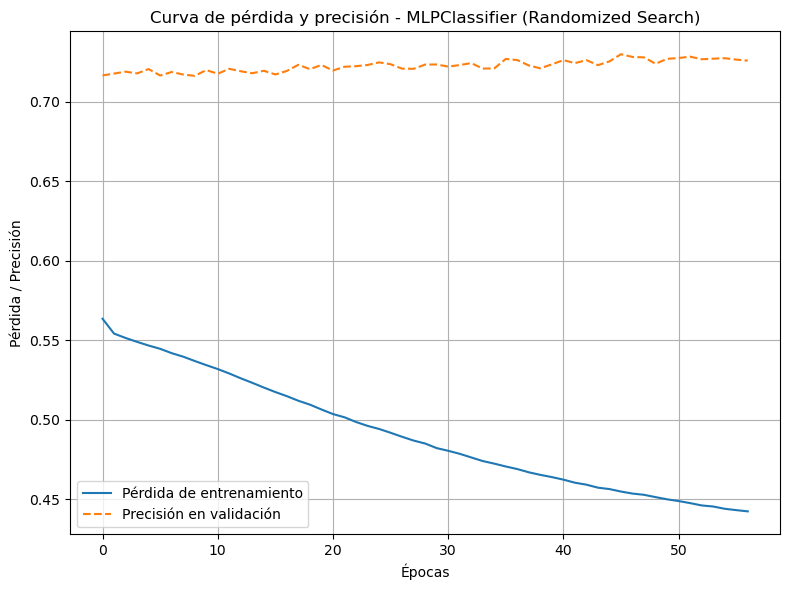

In [18]:
# Show the loss curve for the MLP Classifier during training, along with the accuracy during validation
plot_mlp_loss_curve(best_mlp_model_randomized, 'MLPClassifier (Randomized Search)')

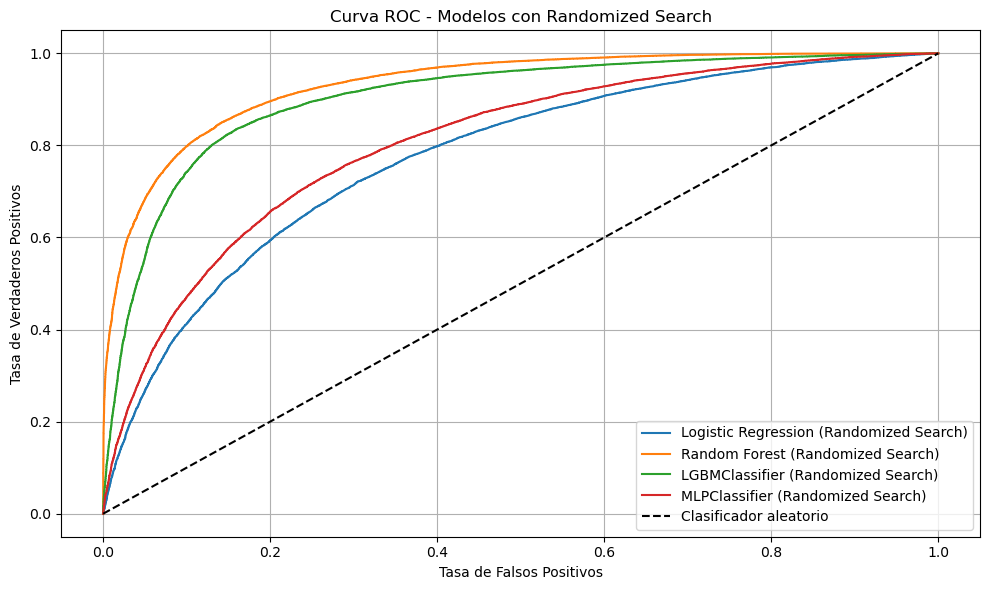

In [19]:
# Randomized models list with their names and probabilities
models_randomized = [
    ('Logistic Regression', y_prob_lr_randomized),
    ('Random Forest', y_prob_rf_randomized),
    ('LGBMClassifier', y_prob_lgb_randomized),
    ('MLPClassifier', y_prob_mlp_randomized)
]

# Initialize the figure for the ROC curve
plt.figure(figsize=(10, 6))

# Plot the ROC curves for the randomized models
for model_name, y_prob in models_randomized:
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (Randomized Search)')

# Display a diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
# Set the rest of the plot properties
plt.title('Curva ROC - Modelos con Randomized Search')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

                Modelo      Configuración  Exactitud  Precisión  Sensibilidad  F1-Score       AUC
1        Random Forest               Base   0.854011   0.851802      0.858360  0.855068  0.938023
5        Random Forest  Randomized Search   0.853046   0.849895      0.858769  0.854309  0.932740
6       LGBMClassifier  Randomized Search   0.837227   0.836172      0.840179  0.838171  0.903737
2       LGBMClassifier               Base   0.760144   0.758918      0.764915  0.761905  0.839454
7        MLPClassifier  Randomized Search   0.733724   0.735802      0.732157  0.733975  0.805187
3        MLPClassifier               Base   0.722465   0.722403      0.725687  0.724041  0.795102
4  Logistic Regression  Randomized Search   0.706872   0.707840      0.707956  0.707898  0.774671
0  Logistic Regression               Base   0.707016   0.707907      0.708284  0.708095  0.774657 



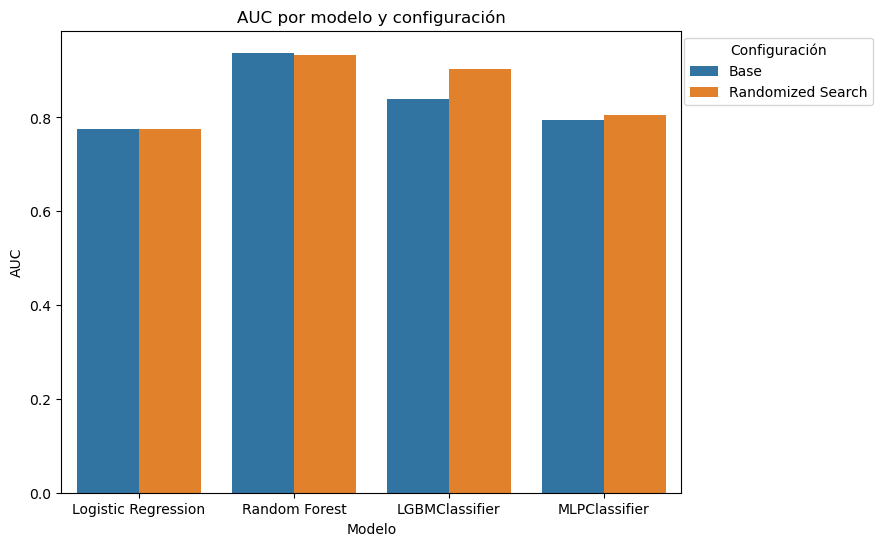

In [20]:
# Show the results of the randomized models
print(models_results.sort_values(by='AUC', ascending=False), '\n')

# Plot the AUC for the randomized models with their configurations
plt.figure(figsize=(8, 6))
sns.barplot(data=models_results, x='Modelo', y='AUC', hue='Configuración')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.32, 1))
plt.title('AUC por modelo y configuración')
plt.xlabel('Modelo')
plt.ylabel('AUC')
plt.show()

## Evaluation of the Grid Search models

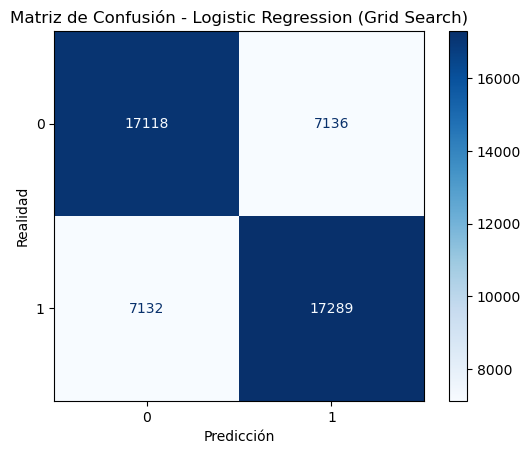

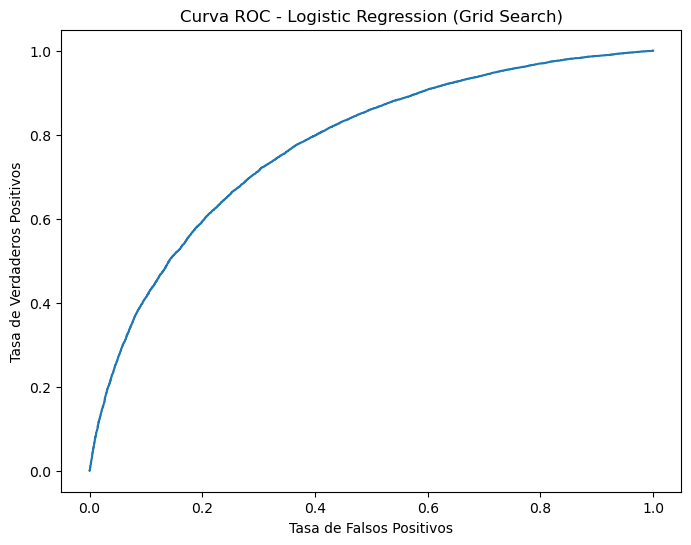

In [21]:
# Load the best Logistic Regression model from GridSearchCV
# This model is already trained and saved in the './models/gridsearch/' folder
best_lr_model_gridsearch = joblib.load('./models/gridsearch/best_lr_model_gridsearch.pkl')

# Evaluate the best Logistic Regression model
res_lr_gridsearch, y_pred_lr_gridsearch, y_prob_lr_gridsearch = evaluate_model('Logistic Regression', 'Grid Search', best_lr_model_gridsearch, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_lr_gridsearch, 'Logistic Regression', 'Grid Search')

# Store the results of the best Logistic Regression model
models_results = pd.concat([models_results, res_lr_gridsearch], ignore_index=True)

# Plot ROC curve for Logistic Regression with Grid Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_lr_gridsearch, 'Logistic Regression', 'Grid Search')
plt.title('Curva ROC - Logistic Regression (Grid Search)')
plt.show()

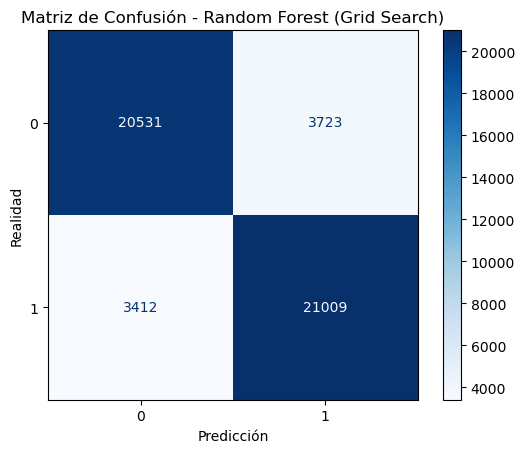

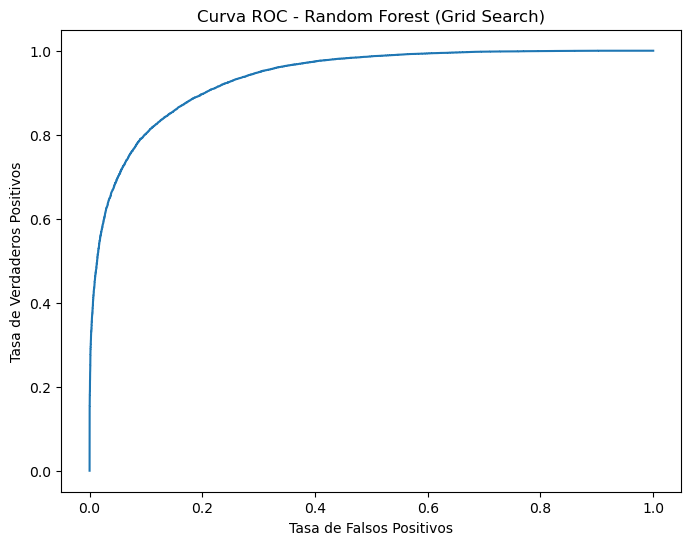

In [22]:
# Load the best Random Forest model from GridSearchCV
# This model is already trained and saved in the './models/gridsearch/' folder
best_rf_model_gridsearch = joblib.load('./models/gridsearch/best_rf_model_gridsearch.pkl')

# Evaluate the best Random Forest model
res_rf_gridsearch, y_pred_rf_gridsearch, y_prob_rf_gridsearch = evaluate_model('Random Forest', 'Grid Search', best_rf_model_gridsearch, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_rf_gridsearch, 'Random Forest', 'Grid Search')

# Store the results of the best Random Forest model
models_results = pd.concat([models_results, res_rf_gridsearch], ignore_index=True)

# Plot ROC curve for Random Forest with Grid Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_rf_gridsearch, 'Random Forest', 'Grid Search')
plt.title('Curva ROC - Random Forest (Grid Search)')
plt.show()

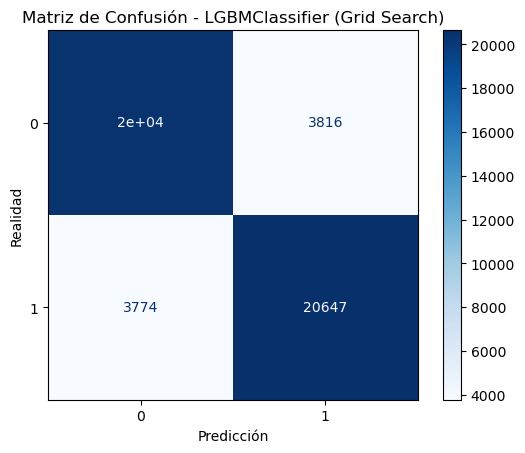

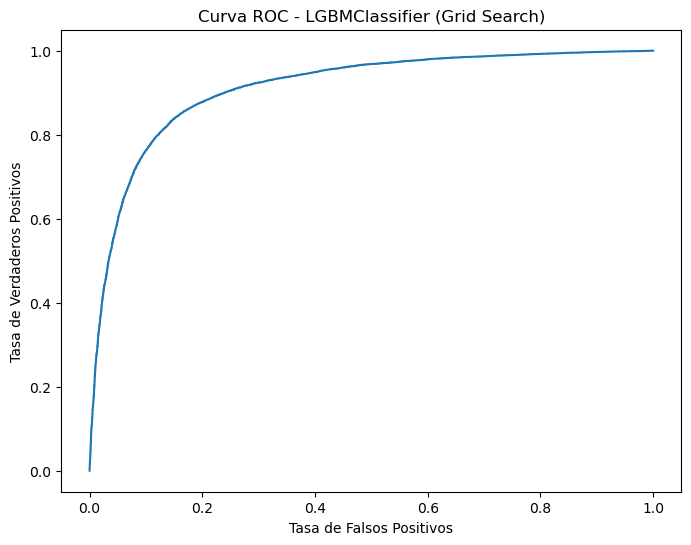

In [23]:
# Load the best LightGBM model from GridSearchCV
# This model is already trained and saved in the './models/gridsearch/' folder
best_lgb_model_gridsearch = joblib.load('./models/gridsearch/best_lgb_model_gridsearch.pkl')

# Evaluate the best LightGBM model
res_lgb_gridsearch, y_pred_lgb_gridsearch, y_prob_lgb_gridsearch = evaluate_model('LGBMClassifier', 'Grid Search', best_lgb_model_gridsearch, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_lgb_gridsearch, 'LGBMClassifier', 'Grid Search')

# Store the results of the best LightGBM model
models_results = pd.concat([models_results, res_lgb_gridsearch], ignore_index=True)

# Plot ROC curve for LGBM Classifier with Grid Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_lgb_gridsearch, 'LGBMClassifier', 'Grid Search')
plt.title('Curva ROC - LGBMClassifier (Grid Search)')
plt.show()

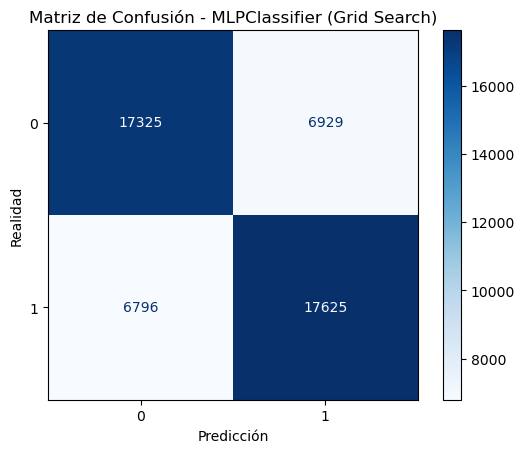

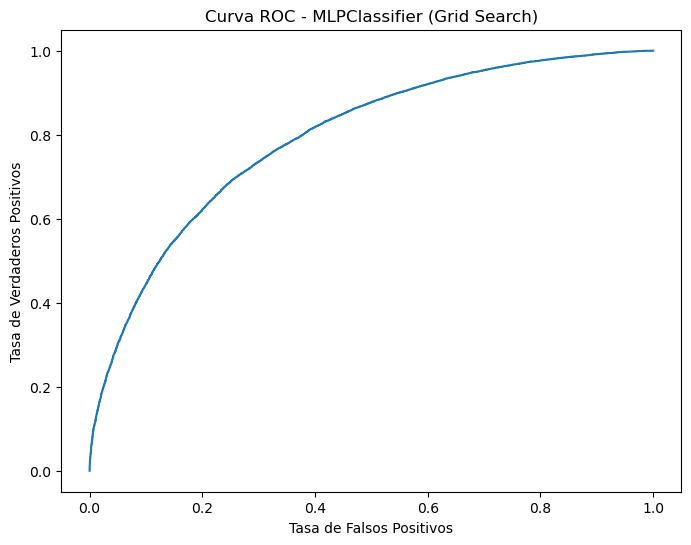

In [24]:
# Load the best MLP Classifier model from GridSearchCV
# This model is already trained and saved in the './models/gridsearch/' folder
best_mlp_model_gridsearch = joblib.load('./models/gridsearch/best_mlp_model_gridsearch.pkl')

# Evaluate the best MLP Classifier model
res_mlp_gridsearch, y_pred_mlp_gridsearch, y_prob_mlp_gridsearch = evaluate_model('MLPClassifier', 'Grid Search', best_mlp_model_gridsearch, X_test, y_test)
plot_confusion_matrix(y_test, y_pred_mlp_gridsearch, 'MLPClassifier', 'Grid Search')

# Store the results of the best MLP Classifier model
models_results = pd.concat([models_results, res_mlp_gridsearch], ignore_index=True)

# Plot ROC curve for MLP Classifier with Grid Search
plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_prob_mlp_gridsearch, 'MLPClassifier', 'Grid Search')
plt.title('Curva ROC - MLPClassifier (Grid Search)')
plt.show()

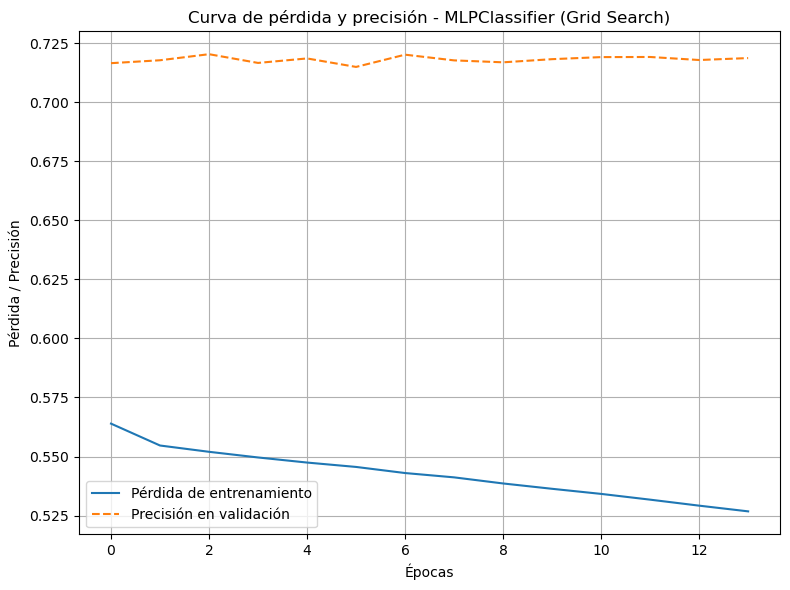

In [25]:
# Show the loss curve for the MLP Classifier during training, along with the accuracy during validation
plot_mlp_loss_curve(best_mlp_model_gridsearch, 'MLPClassifier (Grid Search)')

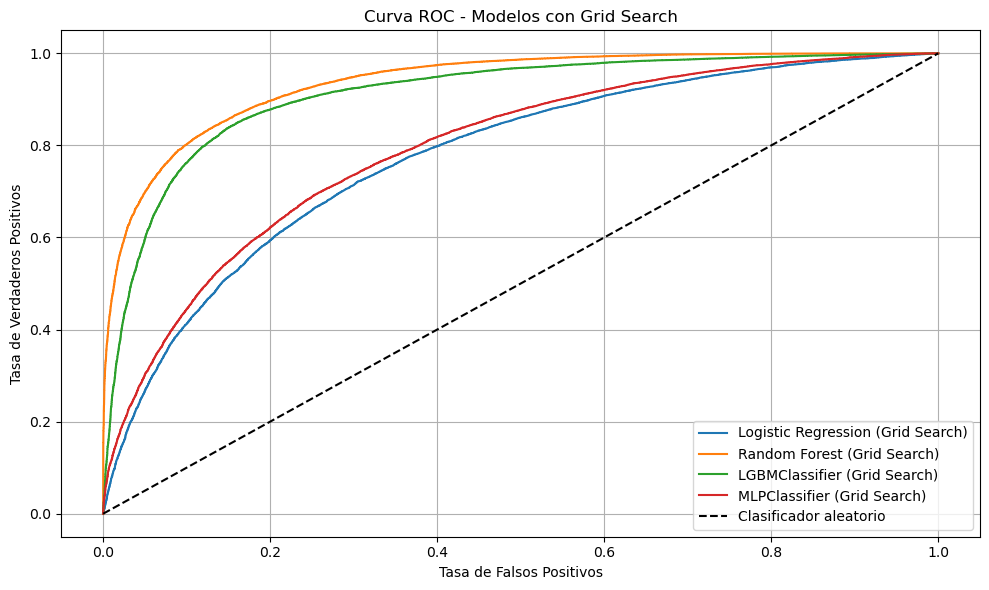

In [26]:
# Grid search models list with their names and probabilities
models_gridsearch = [
    ('Logistic Regression', y_prob_lr_gridsearch),
    ('Random Forest', y_prob_rf_gridsearch),
    ('LGBMClassifier', y_prob_lgb_gridsearch),
    ('MLPClassifier', y_prob_mlp_gridsearch)
]

# Initialize the figure for the ROC curve
plt.figure(figsize=(10, 6))

# Plot the ROC curves for the grid search models
for model_name, y_prob in models_gridsearch:
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (Grid Search)')

# Display a diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
# Set the rest of the plot properties
plt.title('Curva ROC - Modelos con Grid Search')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

                 Modelo      Configuración  Exactitud  Precisión  Sensibilidad  F1-Score       AUC
1         Random Forest               Base   0.854011   0.851802      0.858360  0.855068  0.938023
9         Random Forest        Grid Search   0.853416   0.849466      0.860284  0.854841  0.936806
5         Random Forest  Randomized Search   0.853046   0.849895      0.858769  0.854309  0.932740
10       LGBMClassifier        Grid Search   0.844068   0.844009      0.845461  0.844734  0.911365
6        LGBMClassifier  Randomized Search   0.837227   0.836172      0.840179  0.838171  0.903737
2        LGBMClassifier               Base   0.760144   0.758918      0.764915  0.761905  0.839454
7         MLPClassifier  Randomized Search   0.733724   0.735802      0.732157  0.733975  0.805187
3         MLPClassifier               Base   0.722465   0.722403      0.725687  0.724041  0.795102
11        MLPClassifier        Grid Search   0.718028   0.717806      0.721715  0.719755  0.792357
4   Logist

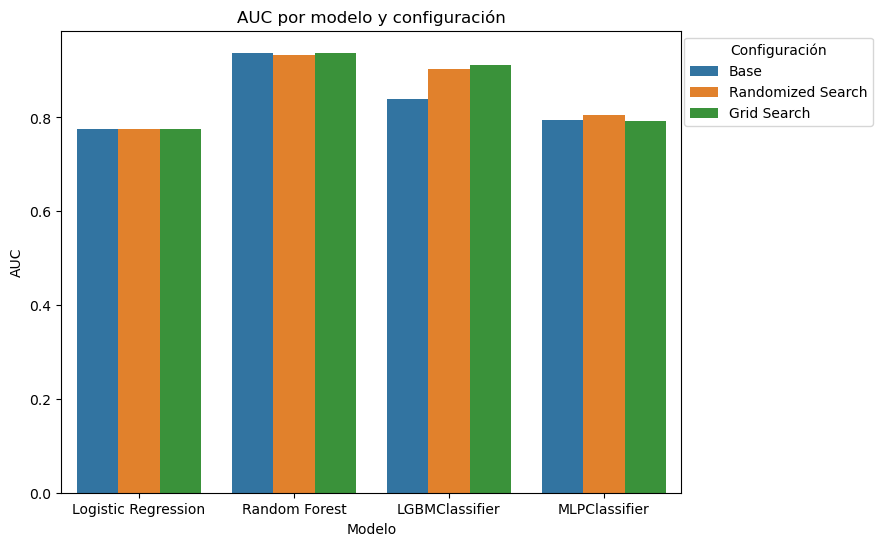

In [27]:
# Show the results of the grid search models
print(models_results.sort_values(by='AUC', ascending=False), '\n')

# Plot the AUC for the grid search models with their configurations
plt.figure(figsize=(8, 6))
sns.barplot(data=models_results, x='Modelo', y='AUC', hue='Configuración')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.32, 1))
plt.title('AUC por modelo y configuración')
plt.xlabel('Modelo')
plt.ylabel('AUC')
plt.show()

## View feature importances for different models

In [28]:
# Using the best configuration for each kind of model
# As the models are already trained and saved, a sample of 1000 rows from the train set is used to calculate the SHAP values 
X_sample = X_train.sample(1000, random_state=42)

## Logistic Regression

In [29]:
# Explain the best Logistic Regression model using SHAP
explainer_lr = shap.LinearExplainer(best_lr_model_randomized, X_sample)
shap_values_lr = explainer_lr.shap_values(X_sample) # Calculate SHAP values

In [30]:
print(f"SHAP shape for Logistic Regression: {shap_values_lr.shape}")
print("X_sample shape:", X_sample.shape)

SHAP shape for Logistic Regression: (1000, 39)
X_sample shape: (1000, 39)


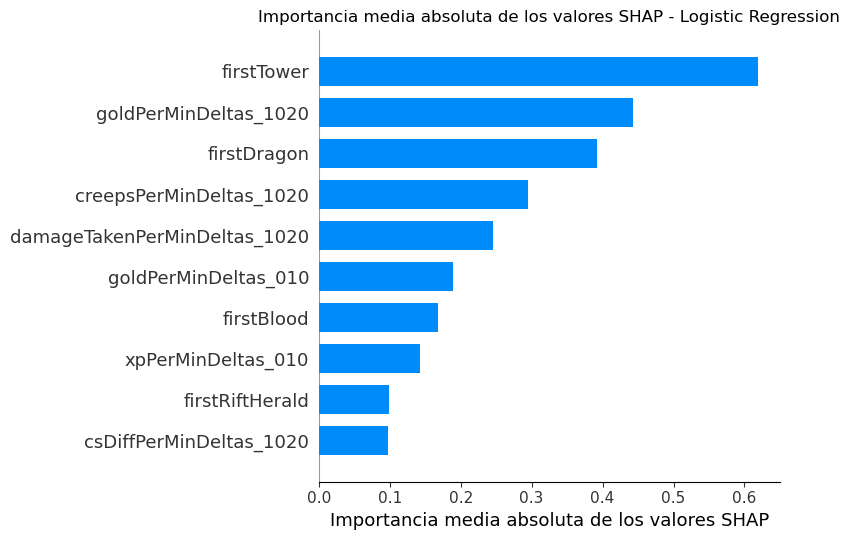

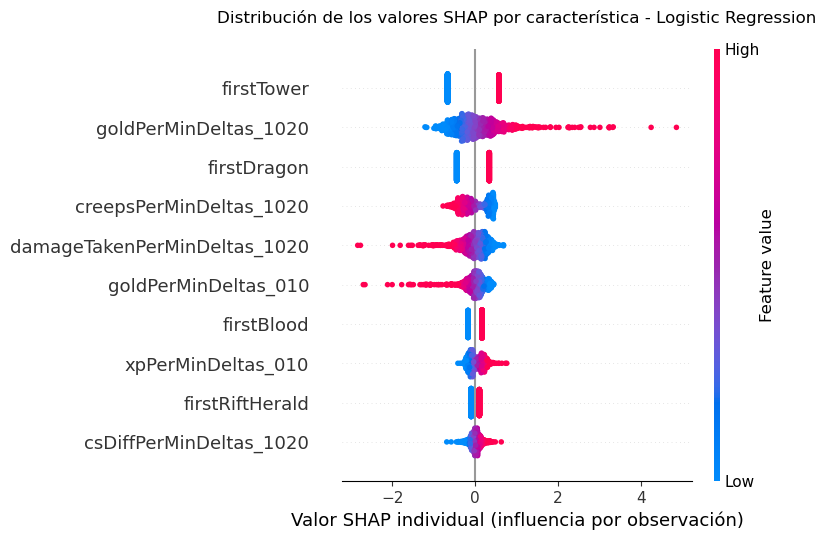

In [31]:
# Bar plot to show mean abosulte importance of the features
shap.summary_plot(shap_values_lr, X_sample, plot_type="bar", feature_names=X.columns, max_display=10, show=False)
plt.title('Importancia media absoluta de los valores SHAP - Logistic Regression')
plt.xlabel('Importancia media absoluta de los valores SHAP')
plt.tight_layout()
plt.show()
# Force plot to show how values influence the model's prediction
shap.summary_plot(shap_values_lr, X_sample, feature_names=X.columns, max_display=10, show=False)
plt.title('Distribución de los valores SHAP por característica - Logistic Regression\n')
plt.xlabel('Valor SHAP individual (influencia por observación)')
plt.tight_layout()
plt.show()

## Random Forest

In [32]:
# Explain the best random forest model using SHAP
explainer_rf = shap.TreeExplainer(random_forest)
shap_values_rf = explainer_rf.shap_values(X_sample) # Calculate SHAP values

In [33]:
print(f"SHAP shape for Random Forest: {shap_values_rf.shape}") # 3D array (n_samples, n_features, n_classes)
print("X_sample shape:", X_sample.shape)

SHAP shape for Random Forest: (1000, 39, 2)
X_sample shape: (1000, 39)


In [34]:
# Get the SHAP values for the victory class (1)
shap_values_rf_victory = shap_values_rf[:, :, 1]
print(shap_values_rf_victory.shape)

(1000, 39)


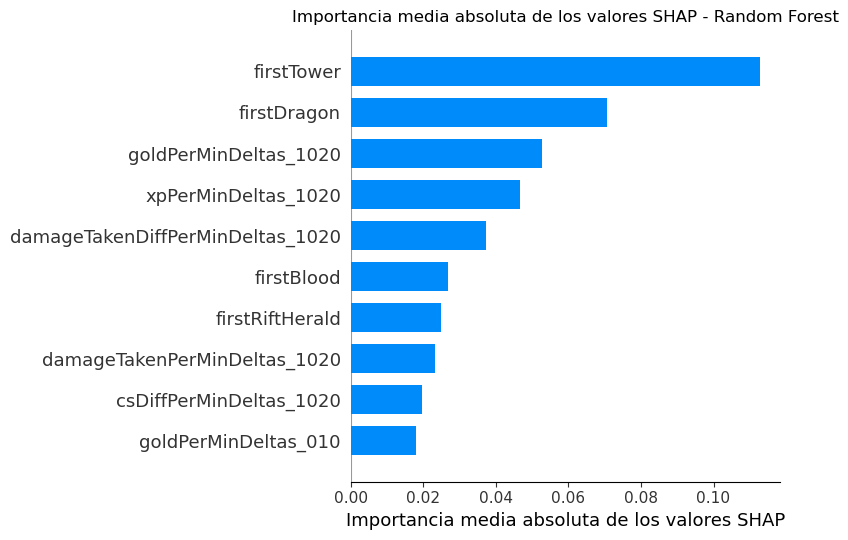

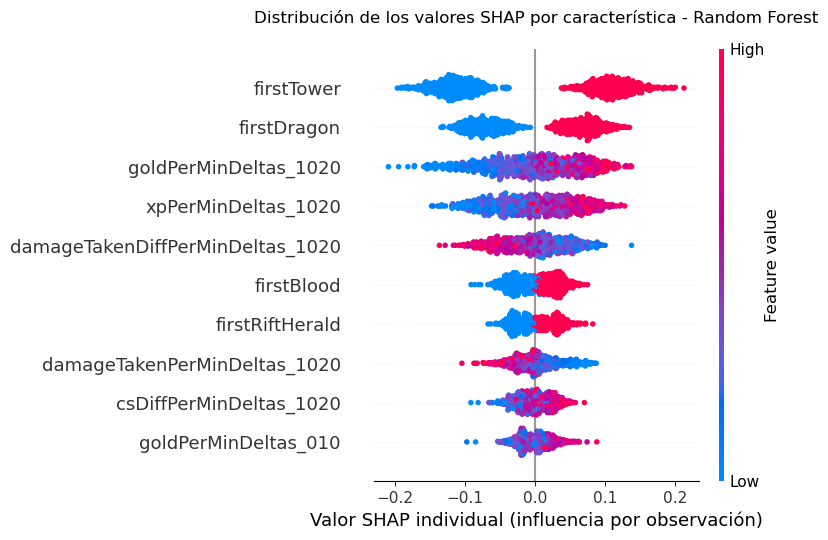

In [35]:
# Bar plot to show mean abosulte importance of the features
shap.summary_plot(shap_values_rf_victory, X_sample, plot_type="bar", max_display=10, show=False)
plt.title('Importancia media absoluta de los valores SHAP - Random Forest')
plt.xlabel('Importancia media absoluta de los valores SHAP')
plt.tight_layout()
plt.show()
# Force plot to show how values influence the model's prediction
shap.summary_plot(shap_values_rf_victory, X_sample, max_display=10, show=False)
plt.title('Distribución de los valores SHAP por característica - Random Forest\n')
plt.xlabel('Valor SHAP individual (influencia por observación)')
plt.tight_layout()
plt.show()

## LGBMClassifier

In [36]:
# Explain the best LGBMClassifier model using SHAP
explainer_lgb = shap.TreeExplainer(best_lgb_model_gridsearch)
shap_values_lgb = explainer_lgb.shap_values(X_sample) # Calculate SHAP values

In [37]:
print(f"SHAP shape for LGBMClassifier: {shap_values_lgb.shape}")
print("X_sample shape:", X_sample.shape)

SHAP shape for LGBMClassifier: (1000, 39)
X_sample shape: (1000, 39)


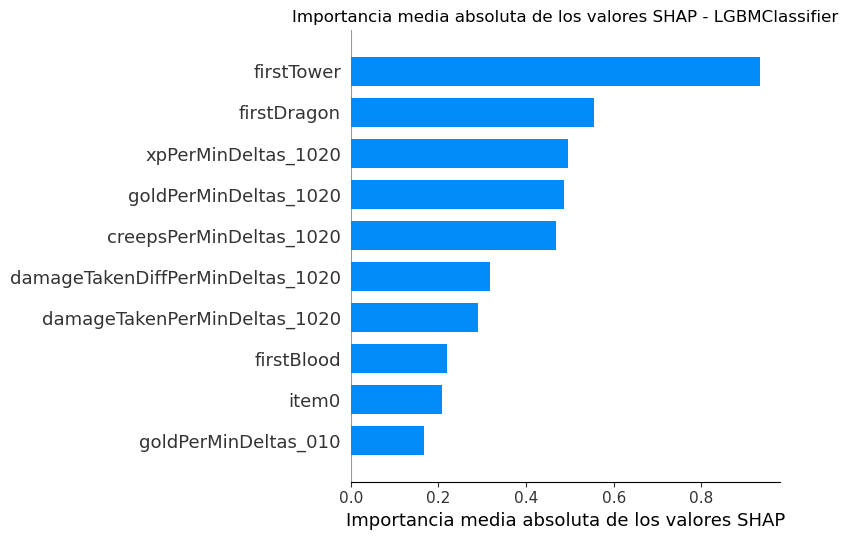

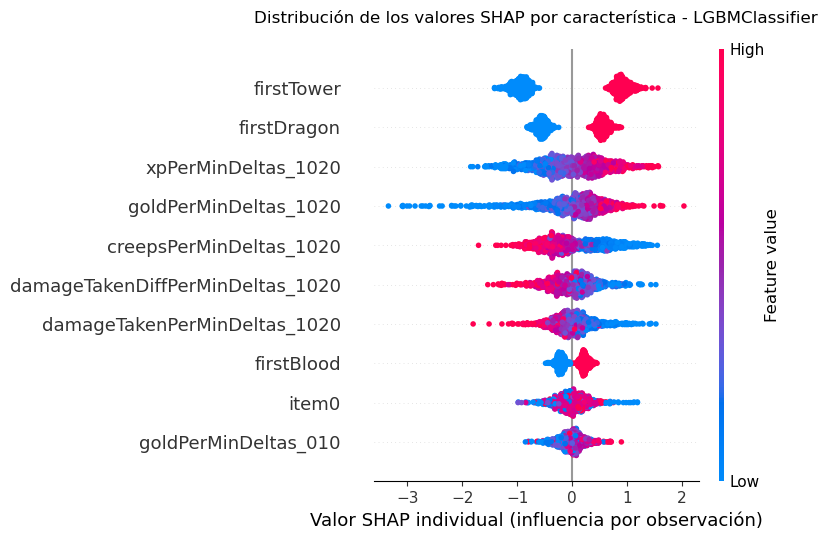

In [38]:
# Bar plot to show mean abosulte importance of the features
shap.summary_plot(shap_values_lgb, X_sample, plot_type="bar", feature_names=X.columns, max_display=10, show=False)
plt.title('Importancia media absoluta de los valores SHAP - LGBMClassifier')
plt.xlabel('Importancia media absoluta de los valores SHAP')
plt.tight_layout()
plt.show()
# Force plot to show how values influence the model's prediction
shap.summary_plot(shap_values_lgb, X_sample, feature_names=X.columns, max_display=10, show=False)
plt.title('Distribución de los valores SHAP por característica - LGBMClassifier\n')
plt.xlabel('Valor SHAP individual (influencia por observación)')
plt.tight_layout()
plt.show()

## MLPClassifier

In [39]:
# Explain the best MLPClassifier model using SHAP
explainer_mlp = shap.KernelExplainer(best_mlp_model_randomized.predict_proba, X_sample)
shap_values_mlp = explainer_mlp.shap_values(X_sample)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
print(f"SHAP shape for MLPClassifier: {shap_values_mlp.shape}") # 3D array (n_samples, n_features, n_classes)
print("X_sample shape:", X_sample.shape)

SHAP shape for MLPClassifier: (1000, 39, 2)
X_sample shape: (1000, 39)


In [41]:
# Get the SHAP values for the victory class (1)
shap_values_mlp_victory = shap_values_mlp[:, :, 1]
print(shap_values_mlp_victory.shape)

(1000, 39)


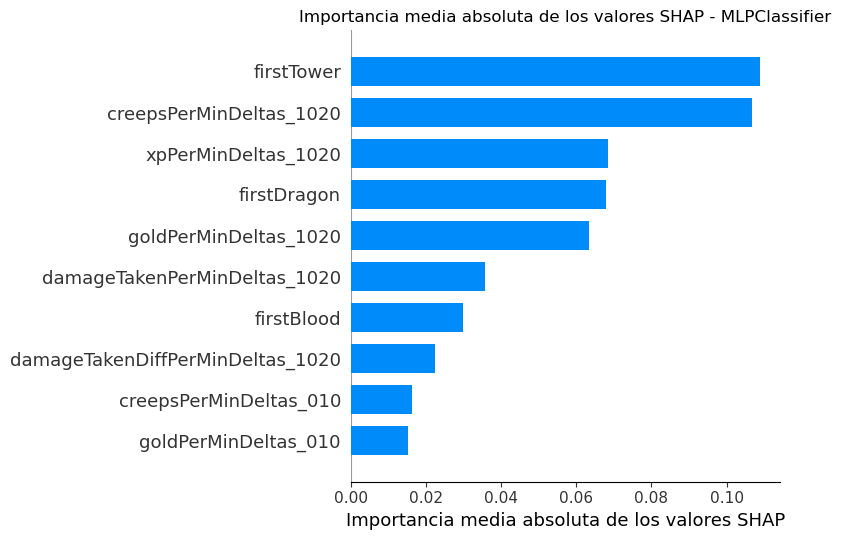

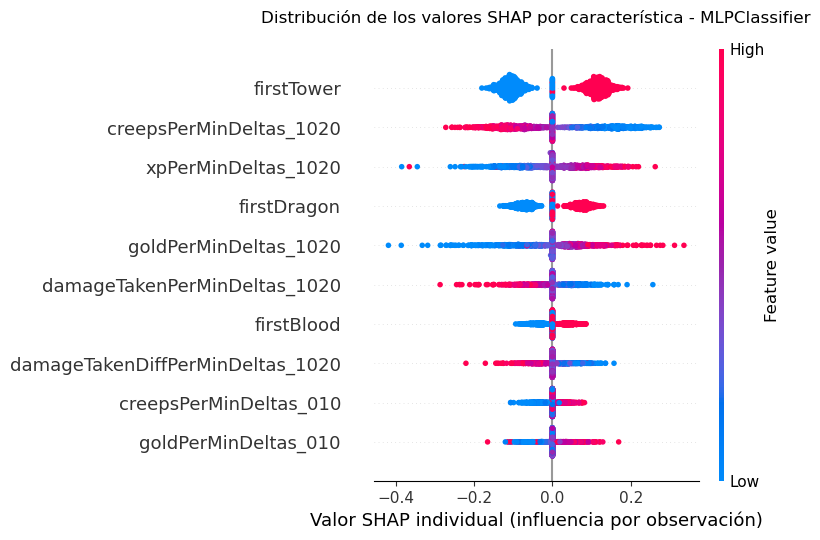

In [42]:
# Bar plot to show mean abosulte importance of the features
shap.summary_plot(shap_values_mlp_victory, X_sample, plot_type="bar", max_display=10, show=False)
plt.title('Importancia media absoluta de los valores SHAP - MLPClassifier')
plt.xlabel('Importancia media absoluta de los valores SHAP')
plt.tight_layout()
plt.show()
# Force plot to show how values influence the model's prediction
shap.summary_plot(shap_values_mlp_victory, X_sample, max_display=10, show=False)
plt.title('Distribución de los valores SHAP por característica - MLPClassifier\n')
plt.xlabel('Valor SHAP individual (influencia por observación)')
plt.tight_layout()
plt.show()